In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys, os, time
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import pickle
import torch
import random
import utils

import data_handler
from sklearn.utils import shuffle
import trainer
import networks


In [25]:
args = {}

# general experimental setting 
args['date'] = '210806'
args['dataset'] = 'MNIST'
args['trainer'] = 'ewc' # ER or EWC
args['seed'] = 0
args['output_path'] = '' # this is corrected at the next cell

# setting for continual learning 
args['tasknum'] = 5

#hyperparameter for optimization
args['batch_size'] = 256
args['lr'] = 0.001
args['epochs'] = 10
args['decay'] = 0 # weight decay (L2 penaly for general regularization)

args['schedule_milestone'] = [7] #Decrease learning rate at these epochs
args['gamma'] = 0.2


#hyperparameter for EWC
args['lamb'] = 1

# for GPU, if you cannot use GPU, set device as None
device = 0
if device is not None:
    torch.cuda.set_device(device)

In [26]:
# Make directory for saving datasets, output files and trained models.
if not os.path.isdir('dat'):
    print('Make directory for dataset')
    os.makedirs('dat')

if not os.path.isdir('result_data'):
    print('Make directory for saving results')
    os.makedirs('result_data')

if not os.path.isdir('trained_model'):
    print('Make directory for saving trained models')
    os.makedirs('trained_model')

# Make filename of a file for logging a result
log_name = '{}_{}_{}_{}_lamb_{}_lr_{}_batch_{}_epoch_{}'.format(args['date'], args['dataset'], args['trainer'],args['seed'], 
                                                                       args['lamb'], args['lr'], args['batch_size'], args['epochs'])

if args['output_path'] == '':
    args['output_path'] = './result_data/' + log_name + '.txt'


In [27]:
# Fix seed for deterministic results
np.random.seed(args['seed'])
random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True
# device = torch.device("gpu")
# torch.backends.cudnn.benchmark = False


In [28]:
#Load a dataset and a dataloader that outputs a task sequentially
print('Load data...')
data_dict = None
dataset = data_handler.DatasetFactory.get_dataset(args['dataset'], args['tasknum'])
task_info = dataset.task_info
print('\nTask info =', task_info)

# Loader used for training data
shuffle_idx = shuffle(np.arange(dataset.classes), random_state=args['seed'])

# list of dataloaders: it consists of dataloaders for each task
train_dataset_loaders = data_handler.make_ContinualLoaders(dataset.train_data,
                                                        dataset.train_labels,
                                                        task_info,
                                                        transform=dataset.train_transform,
                                                        shuffle_idx = shuffle_idx,
                                                        data_dict = data_dict,
                                                       )

test_dataset_loaders = data_handler.make_ContinualLoaders(dataset.test_data,
                                                       dataset.test_labels,
                                                       task_info,
                                                       transform=dataset.test_transform,
                                                       shuffle_idx = shuffle_idx,
                                                       data_dict = data_dict,
                                                      )



Load data...

Task info = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]


c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [29]:
# Get the required model
if device is not None:
    myModel = networks.ModelFactory.get_model(args['dataset'], args['trainer'], task_info).to(device)
else:
    myModel = networks.ModelFactory.get_model(args['dataset'], args['trainer'], task_info)

# Define the optimizer used in the experiment
optimizer = torch.optim.Adam(myModel.parameters(), lr=args['lr'], weight_decay=args['decay'])

# Initilize the evaluators used to measure the performance of the system.
t_classifier = trainer.EvaluatorFactory.get_evaluator("trainedClassifier")


In [30]:
class Trainer(trainer.GenericTrainer):
    def __init__(self, model, args, optimizer, evaluator, task_info):
        super().__init__(model, args, optimizer, evaluator, task_info)
        
        self.lamb=args['lamb']
        

    def train(self, train_loader, test_loader, t, device = None):
        
        self.device = device
        self.setup_training(self.lr)
        # Do not update self.t
        if t>0: # update fisher before starting training new task
            self.update_frozen_model()
            self.update_fisher(device)
        
        # Now, you can update self.t
        self.t = t
        
        self.train_iterator = torch.utils.data.DataLoader(train_loader, batch_size=self.batch_size, shuffle=True)
        self.test_iterator = torch.utils.data.DataLoader(test_loader, 100, shuffle=False)
        self.fisher_iterator = torch.utils.data.DataLoader(train_loader, batch_size=20, shuffle=True)
        
        for epoch in range(self.epochs):
            self.model.train()
            for samples in self.train_iterator:
                data, target = samples
                if device is not None:
                    data, target = data.to(device), target.to(device)

                output = self.model(data)[t]
                loss_CE = self.criterion(output,target)

                self.optimizer.zero_grad()
                (loss_CE).backward()
                self.optimizer.step()
            self.scheduler.step()

            train_loss,train_acc = self.evaluator.evaluate(self.model, self.train_iterator, t, self.device)
            num_batch = len(self.train_iterator)
            print('| Epoch {:3d} | Train: loss={:.3f}, acc={:5.1f}% |'.format(epoch+1,train_loss,100*train_acc),end='')
            test_loss,test_acc=self.evaluator.evaluate(self.model, self.test_iterator, t, self.device)
            print(' Test: loss={:.3f}, acc={:5.1f}% |'.format(test_loss,100*test_acc),end='')
            print()
        
    def criterion(self,output,targets):
        """
        Arguments: output (The output logit of self.model), targets (Ground truth label)
        Return: loss function for the regularization-based continual learning
        
        For the hyperparameter on regularization, please use self.lamb
        """
        #######################################################################################
        # Write youre code here
        #######################################################################################
        reg = 0
        if self.t > 0:
            for (name, param), (_, param_fixed) in zip(self.model.named_parameters(), self.model_fixed.named_parameters()):
                reg += torch.sum(self.fisher[name] * (param - param_fixed).pow(2))

        return self.ce(output,targets) + self.lamb * reg
    
    def compute_diag_fisher(self, device=None):
        """
        Arguments: None. Just use global variables (self.model, self.criterion, ...)
        Return: Diagonal Fisher matrix. 
        
        This function will be used in the function 'update_fisher'
        """
        #######################################################################################
        # Write youre code here
        #######################################################################################
        fisher = {}
        for (name, param) in self.model.named_parameters():
            fisher[name]= 0 * param.data # torch.zeros_like(param)

        # accumulate the diag of FIM
        total = 0
        for data, target in self.fisher_iterator:
            output = self.model(data)[self.t]
            loss = self.ce(output, target)

            self.model.zero_grad()
            loss.backward()
        
        for (name, param) in self.model.named_parameters():
            if param.grad is not None:
                fisher[name] += param.grad.pow(2)
        
        total +=1

        # average
        for (name, param) in self.model.named_parameters():
            fisher[name] /= total
            
        return fisher
    
    def update_fisher(self, device):
        
        """
        Arguments: None. Just use global variables (self.model, self.fisher, ...)
        Return: None. Just update the global variable self.fisher
        Use 'compute_diag_fisher' to compute the fisher matrix
        
        hint : pytorch function
        pseudo code
        """
        #######################################################################################
        #  Write youre code here
        #######################################################################################
        fisher = self.compute_diag_fisher()
        if self.t > 0:
            for key in self.fisher.keys():
                self.fisher[key] += fisher[key]
        else:
            self.fisher = fisher
        return fisher


In [31]:
# Trainer object used for training
myTrainer = Trainer(myModel, args, optimizer, t_classifier, task_info)


In [32]:
########################################################################################################################

utils.print_model_report(myModel)
utils.print_optimizer_config(optimizer)
print('-' * 100)

# Loop tasks
acc = np.zeros((len(task_info), len(task_info)), dtype=np.float32)
lss = np.zeros((len(task_info), len(task_info)), dtype=np.float32)
for t, ncla in task_info:
    print("tasknum:", t)
    # Add new classes to the train, and test iterator

    train_loader = train_dataset_loaders[t]
    test_loader = test_dataset_loaders[t]
    print(device)
    myTrainer.train(train_loader, test_loader, t, device)

    for u in range(t+1):
        test_loader = test_dataset_loaders[u]
        test_iterator = torch.utils.data.DataLoader(test_loader, 100, shuffle=False)
        test_loss, test_acc = t_classifier.evaluate(myTrainer.model, test_iterator, u, device)
        print('>>> Test on task {:2d}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, test_loss, 100 * test_acc))
        acc[t, u] = test_acc
        lss[t, u] = test_loss

    print('Average accuracy={:5.1f}%'.format(100 * np.mean(acc[t,:t+1])))

    print('Save at ' + args['output_path'])
    np.savetxt(args['output_path'], acc, '%.4f')
    torch.save(myModel.state_dict(), './trained_model/' + log_name + '_task_{}.pt'.format(t))


print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')






----------------------------------------------------------------------------------------------------
MLP_Net(
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (last): ModuleList(
    (0): Linear(in_features=400, out_features=2, bias=True)
    (1): Linear(in_features=400, out_features=2, bias=True)
    (2): Linear(in_features=400, out_features=2, bias=True)
    (3): Linear(in_features=400, out_features=2, bias=True)
    (4): Linear(in_features=400, out_features=2, bias=True)
  )
)
Dimensions = torch.Size([400, 784]) torch.Size([400]) torch.Size([400, 400]) torch.Size([400]) torch.Size([2, 400]) torch.Size([2]) torch.Size([2, 400]) torch.Size([2]) torch.Size([2, 400]) torch.Size([2]) torch.Size([2, 400]) torch.Size([2]) torch.Size([2, 400]) torch.Size([2]) 
Num parameters = 478.4K
----------------------------------------------------------------------------

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'

In [35]:
def avg_acc(file_name):
    acc_arr = np.loadtxt(file_name)
    avg_acc_arr = np.zeros(acc_arr.shape[1])
    for i in range(acc_arr.shape[1]):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr
filename = 'result_data/210806_MNIST_ewc_0_lamb_1_lr_0.001_batch_256_epoch_10.txt'
results = avg_acc(filename)
print(results)


[0.9954     0.9499     0.96476667 0.963475   0.95766   ]


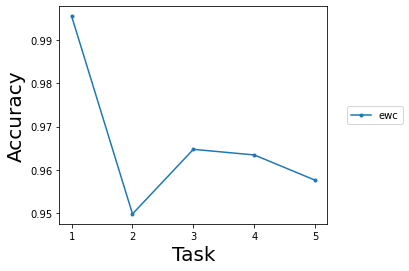

In [36]:
import matplotlib.pyplot as plt
task_num = args['tasknum']
task = np.arange(task_num) +1
ax = plt.subplot(111)
    
# for key in results.keys():
ax.plot(task, results, label = 'ewc', linestyle = '-', marker = '.')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xticks(task)

plt.xlabel('Task',fontsize = 20)
plt.ylabel('Accuracy',fontsize = 20)

ax.legend(loc = 'center right', bbox_to_anchor=(1.3, 0.5))
plt.show()



